In [1]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns


In [2]:
# Import models
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.feature_bagging import FeatureBagging

In [3]:
# reading the dataset
df = pd.read_csv("rca.csv")

<AxesSubplot:xlabel='latency', ylabel='source'>

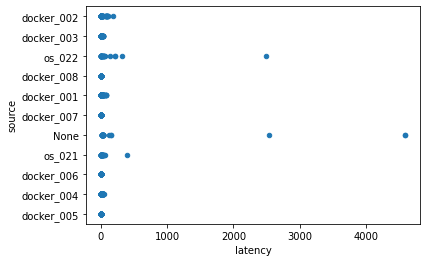

In [4]:
df.plot.scatter('latency', 'source')

In [5]:
le = preprocessing.LabelEncoder()
le.fit(df['source'])
LabelEncoder()
list(le.classes_)
sourceTransformed = le.transform(df['source'])

In [6]:
X1 = df['latency'].values.reshape(-1,1)
X2 = sourceTransformed.reshape(-1,1)

print(X1)
print(X2)

X = np.concatenate((X1,X2), axis=1)

[[ 4]
 [ 2]
 [ 2]
 ...
 [ 1]
 [14]
 [ 0]]
[[5]
 [5]
 [5]
 ...
 [7]
 [1]
 [1]]


In [ ]:
# le = preprocessing.LabelEncoder()
# test = pd.DataFrame(df.source)
# sourceTransformed = le.fit_transform(test.values)


# X1 = df.latency.values.reshape(-1,1)
# X2 = sourceTransformed.reshape(-1,1)

# print(X1)
# print(X2)

# X = np.concatenate((X1,X2), axis=1)

In [7]:
outliers_fraction = 0.1
# Test 4 different methods
classifiers = {
        'FeatureBagging': FeatureBagging(contamination=outliers_fraction),
        'KNN': KNN(contamination=outliers_fraction),
        'HBOS': HBOS(contamination=outliers_fraction),
        'IForest': IForest(contamination=outliers_fraction)
}

[-9.00000001e+08 -1.00000000e+00 -1.00000000e+00 ... -3.00000001e+08
 -1.01062958e+00 -1.00000000e+00]
OUTLIERS :  199 INLIERS :  1901 FeatureBagging
[0, 3, 15, 54, 55, 60, 61, 73, 75, 79, 86, 88, 92, 94, 96, 98, 100, 108, 111, 112, 113, 115, 118, 119, 123, 156, 158, 167, 170, 171, 173, 176, 177, 188, 190, 228, 229, 235, 248, 286, 287, 297, 304, 318, 320, 328, 330, 332, 336, 343, 344, 345, 347, 351, 355, 370, 378, 386, 403, 405, 415, 457, 460, 461, 463, 478, 521, 531, 576, 577, 579, 582, 632, 634, 635, 637, 692, 693, 695, 698, 703, 705, 747, 750, 751, 753, 756, 757, 768, 809, 811, 819, 821, 826, 833, 866, 867, 873, 877, 880, 924, 925, 937, 981, 982, 983, 985, 995, 1017, 1025, 1031, 1040, 1041, 1047, 1099, 1123, 1157, 1167, 1170, 1182, 1214, 1215, 1221, 1223, 1235, 1273, 1279, 1290, 1331, 1333, 1346, 1353, 1388, 1389, 1391, 1394, 1395, 1399, 1406, 1414, 1447, 1449, 1460, 1480, 1482, 1505, 1507, 1511, 1514, 1520, 1561, 1562, 1563, 1565, 1569, 1571, 1580, 1592, 1617, 1618, 1621, 1623, 162

C:\Users\lauri\AppData\Local\Temp\ipykernel_23976\2217545169.py:45: UserWarning: No contour levels were found within the data range.
  subplot.contour(xx, yy, Z, levels = [threshold], linewidths=2, colors='red')
C:\Users\lauri\AppData\Local\Temp\ipykernel_23976\2217545169.py:48: UserWarning: No contour levels were found within the data range.
  subplot.contour(xx, yy, Z, levels=[threshold, Z.max()], colors='blue')


[-0. -0. -0. ... -0. -1. -0.]
OUTLIERS :  98 INLIERS :  2002 KNN
[3, 55, 61, 75, 92, 104, 112, 113, 115, 119, 158, 169, 171, 173, 177, 191, 228, 229, 235, 287, 297, 304, 320, 334, 345, 347, 351, 370, 378, 390, 403, 405, 409, 415, 416, 460, 461, 467, 519, 521, 577, 579, 583, 597, 635, 641, 693, 695, 751, 809, 811, 819, 822, 833, 867, 877, 927, 983, 1040, 1041, 1099, 1170, 1182, 1273, 1331, 1389, 1447, 1453, 1460, 1507, 1511, 1562, 1565, 1569, 1600, 1613, 1621, 1634, 1679, 1795, 1853, 1911, 1917, 1931, 1940, 1941, 1956, 1961, 1966, 1969, 2027, 2029, 2033, 2040, 2047, 2052, 2058, 2085]
[-4.84125728 -4.84125728 -4.84125728 ... -5.80745033 -6.38457208
 -6.38457208]
OUTLIERS :  3 INLIERS :  2097 HBOS
[173, 347, 811]


C:\Users\lauri\AppData\Local\Temp\ipykernel_23976\2217545169.py:44: UserWarning: No contour levels were found within the data range.
  subplot.contour(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 15))
C:\Users\lauri\AppData\Local\Temp\ipykernel_23976\2217545169.py:45: UserWarning: No contour levels were found within the data range.
  subplot.contour(xx, yy, Z, levels = [threshold], linewidths=2, colors='red')
C:\Users\lauri\AppData\Local\Temp\ipykernel_23976\2217545169.py:48: UserWarning: No contour levels were found within the data range.
  subplot.contour(xx, yy, Z, levels=[threshold, Z.max()], colors='blue')


[0.06833601 0.11820772 0.11820772 ... 0.05513558 0.0124968  0.11864514]
OUTLIERS :  208 INLIERS :  1892 IForest
[3, 10, 55, 56, 57, 61, 75, 92, 104, 113, 114, 115, 119, 126, 158, 169, 171, 172, 173, 177, 184, 191, 229, 230, 231, 235, 248, 287, 288, 289, 293, 300, 304, 312, 320, 334, 345, 346, 347, 351, 358, 370, 378, 390, 403, 404, 405, 409, 416, 423, 428, 461, 462, 463, 467, 474, 481, 486, 519, 520, 521, 525, 577, 578, 579, 583, 590, 597, 602, 635, 636, 637, 641, 693, 694, 695, 699, 713, 751, 752, 753, 757, 771, 809, 810, 811, 815, 819, 822, 867, 868, 869, 873, 877, 880, 925, 926, 927, 931, 983, 984, 985, 989, 1041, 1042, 1043, 1047, 1099, 1100, 1101, 1105, 1119, 1157, 1158, 1159, 1163, 1170, 1207, 1215, 1216, 1217, 1221, 1235, 1240, 1273, 1274, 1275, 1279, 1331, 1332, 1333, 1337, 1389, 1390, 1391, 1395, 1414, 1430, 1447, 1448, 1449, 1453, 1460, 1467, 1480, 1505, 1506, 1507, 1511, 1563, 1564, 1565, 1569, 1576, 1583, 1588, 1600, 1613, 1621, 1622, 1623, 1627, 1634, 1657, 1679, 1680, 168

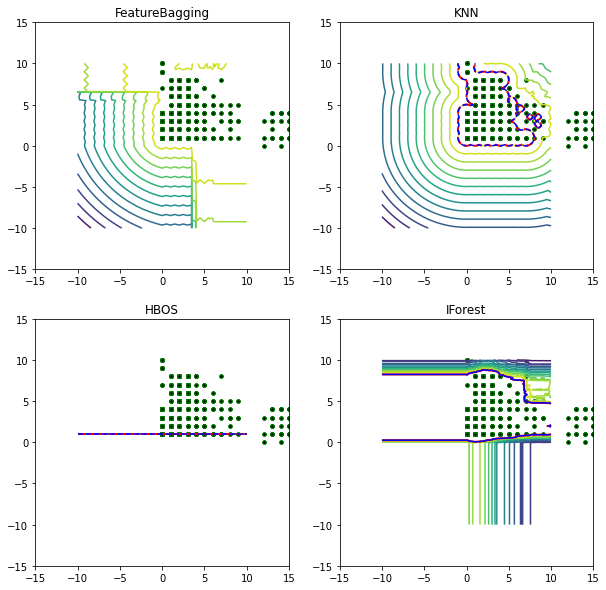

In [8]:
xx , yy = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(-10, 10, 200))
plt.figure(figsize=(10, 10))

for i, (clf_name, clf) in enumerate (classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
    print(scores_pred)

    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    y_pred

    
    np.unique(y_pred, return_counts=True)
    
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)

    outliers = []
    for index in range(len(y_pred)): # returns the total record list discriminated by outlier and inlier
        #print(index)
        if y_pred[index] == 1:
            outliers.append(index)

    print(outliers)

    outliersList = df.iloc[outliers,:]
    outliersList
    # outliers.sort()
    # outliers
    # outliersList.count()

    # threshold value to consider a datapoint inlier or outlier - the probability that the prediction is true
    threshold = stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)

    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)

    # plot outliers and contour
    subplot = plt .subplot(2, 2, i + 1)
    subplot.contour(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 15))
    subplot.contour(xx, yy, Z, levels = [threshold], linewidths=2, colors='red')

    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    subplot.contour(xx, yy, Z, levels=[threshold, Z.max()], colors='blue')

    # scatter plot of inliers with white dots
    subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white', s=12, edgecolor='g')
    # scatter plot of outliers with black dots
    subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='black', s=12, edgecolor='g')
    subplot.axis('tight')

    subplot.set_title(clf_name)
    subplot.set_xlim((-15, 15))
    subplot.set_ylim((-15, 15))
plt.show()
